In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pickle

In [10]:
# Load ALREADY-SPLIT datasets (SOURCE OF TRUTH)
train_df = pd.read_csv(r"C:\Users\caovi\OneDrive\Desktop\projet annuel\core\squat_model/data\squat_train_keypoints.csv")
test_df  = pd.read_csv(r"C:\Users\caovi\OneDrive\Desktop\projet annuel\core\squat_model/data\squat_test_keypoints.csv")

train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df["label"],
    random_state=42
)


X_train = train_df.drop("label", axis=1).values.astype(np.float32)
y_train = train_df["label"].values.astype(np.float32)

X_val = val_df.drop("label", axis=1).values.astype(np.float32)
y_val = val_df["label"].values.astype(np.float32)

X_test = test_df.drop("label", axis=1).values.astype(np.float32)
y_test = test_df["label"].values.astype(np.float32)

# Fit scaler ONLY on TRAIN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Save scaler for live
with open(r"C:\Users\caovi\OneDrive\Desktop\projet annuel\core\squat_model\model\scaler_keypoints_squat.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# SANITY CHECK
print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
print("Label distrib train:", np.unique(y_train.numpy(), return_counts=True))
print("Label distrib test :", np.unique(y_test.numpy(), return_counts=True))

TRAIN: torch.Size([2500, 68]) TEST: torch.Size([1511, 68])
Label distrib train: (array([0., 1.], dtype=float32), array([1440, 1060], dtype=int64))
Label distrib test : (array([0., 1.], dtype=float32), array([ 475, 1036], dtype=int64))


In [11]:
class MLP_Keypoints(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP_Keypoints(input_dim=X_train.shape[1])

In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
EPOCHS = 20

train_losses, val_losses = [], []

for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb).squeeze()
            val_loss += loss_fn(pred, yb).item()

    train_losses.append(total_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))

    print(f"{epoch+1}: train={train_losses[-1]:.4f} | val={val_losses[-1]:.4f}")


1: train=0.3275 | val=0.1465
2: train=0.0851 | val=0.0479
3: train=0.0518 | val=0.0342
4: train=0.0361 | val=0.0168
5: train=0.0231 | val=0.0088
6: train=0.0271 | val=0.0098
7: train=0.0141 | val=0.0021
8: train=0.0143 | val=0.0127
9: train=0.0240 | val=0.0079
10: train=0.0097 | val=0.0195
11: train=0.0302 | val=0.0097
12: train=0.0097 | val=0.0101
13: train=0.0103 | val=0.0087
14: train=0.0108 | val=0.0024
15: train=0.0484 | val=0.0092
16: train=0.0094 | val=0.0020
17: train=0.0066 | val=0.0019
18: train=0.0080 | val=0.0037
19: train=0.0053 | val=0.0009
20: train=0.0020 | val=0.0004


In [14]:
model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze()
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

accuracy = (preds == y_test).float().mean()
print("Accuracy:", accuracy.item())

Accuracy: 0.8901389837265015


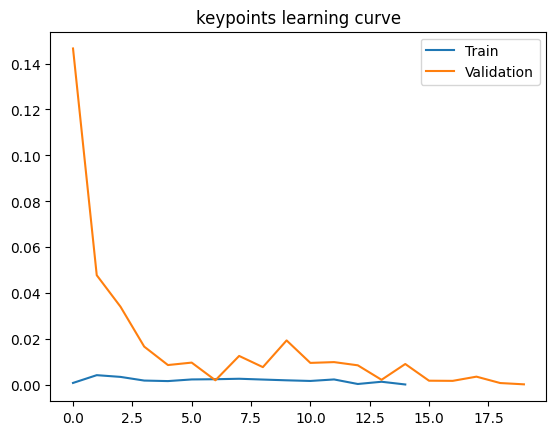

In [19]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train","Validation"])
plt.title("keypoints learning curve")
plt.show()

In [16]:
EPOCHS = 15
train_losses = []
test_losses = []
best_loss = float("inf")
patience = 2
wait = 0

for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    test_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f} - Test Loss: {val_loss:.4f}")

Epoch 1/15 - Train Loss: 0.0010 - Test Loss: 0.5971
Epoch 2/15 - Train Loss: 0.0044 - Test Loss: 0.6319
Epoch 3/15 - Train Loss: 0.0036 - Test Loss: 0.7021
Epoch 4/15 - Train Loss: 0.0020 - Test Loss: 0.9100
Epoch 5/15 - Train Loss: 0.0018 - Test Loss: 0.7394
Epoch 6/15 - Train Loss: 0.0025 - Test Loss: 0.6677
Epoch 7/15 - Train Loss: 0.0026 - Test Loss: 1.0099
Epoch 8/15 - Train Loss: 0.0028 - Test Loss: 0.8171
Epoch 9/15 - Train Loss: 0.0025 - Test Loss: 0.7579
Epoch 10/15 - Train Loss: 0.0021 - Test Loss: 0.7264
Epoch 11/15 - Train Loss: 0.0019 - Test Loss: 0.7455
Epoch 12/15 - Train Loss: 0.0025 - Test Loss: 0.8697
Epoch 13/15 - Train Loss: 0.0005 - Test Loss: 0.9873
Epoch 14/15 - Train Loss: 0.0015 - Test Loss: 0.7721
Epoch 15/15 - Train Loss: 0.0003 - Test Loss: 1.0313


In [17]:
torch.save(model.state_dict(), r"C:\Users\caovi\OneDrive\Desktop\projet annuel\core\squat_model\model\squat_mlp_keypoints.pt")
print("Modèle KEYPOINTS sauvegardé.")

Modèle KEYPOINTS sauvegardé.


In [18]:
model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(X_test)).squeeze()
    preds = (preds > 0.5).float()
    acc = (preds == y_test).float().mean().item()

print("FINAL TEST ACCURACY:", acc)

FINAL TEST ACCURACY: 0.8696227669715881
